In [59]:
import os 
from pathlib import Path
import json

import geopandas as gpd

import matplotlib.pyplot as plt

import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask

In [12]:
# Create paths
data_dir_path = os.path.join(str(Path.home()), "Desktop", "forest_mon", "data")

image_path = os.path.join(data_dir_path, "L8", "LC08_L1TP_149038_20201028_20201106_01_T1_B2.TIF")

aoi_path = os.path.join(data_dir_path, "gardens_edit.json" )

True

In [13]:
# Load area of interest for clipping
aoi = gpd.read_file(aoi_path)

In [19]:
# Load image
band = rio.open(image_path)

In [22]:
# Re-project gdf into same CRS as data
aoi_reproj = aoi.to_crs(crs=band.crs.data)

C:\Users\dphil\Miniconda3\envs\forest\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [44]:
# Convert coordinates into form that rasterio likes
aoi_reproj_json = [json.loads(aoi_reproj.to_json())['features'][0]['geometry']]
#aoi_reproj_json

In [45]:
# Clip the image
out_img, out_transform = mask(dataset=band, shapes=aoi_reproj_json, crop=True)

In [56]:
# Modify metadata: copy from original file
out_meta = band.meta.copy()

# Get epsg code from original data
epsg_code = band.crs.data['init'][5:]

32643


In [57]:
out_img.shape

(1, 3, 2)

In [63]:
# Update metadata with new stuff
out_meta.update({"driver": "GTiff",
                "height": out_img.shape[1],
                "width": out_img.shape[2],
                "transform": out_transform,
                "crs": rio.crs.CRS.from_epsg(epsg_code)})

In [65]:
out_tif = "test_clip.tif"

In [66]:
with rio.open(out_tif, "w", **out_meta) as dest:
    dest.write(out_img)

In [71]:
clipped = rio.open(out_tif)

<AxesSubplot:>

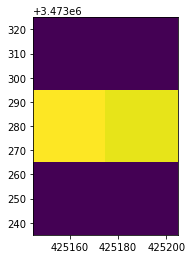

In [76]:
fig, ax = plt.subplots()

show(clipped, ax=ax)

#show(band, ax=ax)